In [30]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import chi2_contingency
from xgboost import XGBClassifier

In [31]:
df = pd.read_csv('C:/Users/yashh/datasets/cleaned_animal_disease_prediction.csv')
df.head()

,Animal_Type,Breed,Age,Gender,Weight,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Duration,...,Diarrhea,Coughing,Labored_Breathing,Lameness,Skin_Lesions,Nasal_Discharge,Eye_Discharge,Body_Temperature,Heart_Rate,Disease_Prediction
0,Dog,Labrador,4,Male,25.0,Fever,Lethargy,Appetite Loss,Vomiting,3 days,...,No,No,No,No,No,No,No,39.5°C,120,Parvovirus
1,Cat,Siamese,2,Female,4.5,Coughing,Sneezing,Eye Discharge,Nasal Discharge,1 week,...,No,Yes,No,No,No,Yes,Yes,38.9°C,150,Upper Respiratory Infection
2,Cow,Holstein,3,Female,600.0,Fever,Nasal Discharge,Labored Breathing,Coughing,5 days,...,No,Yes,Yes,No,No,Yes,No,40.1°C,90,Foot and Mouth Disease
3,Dog,Beagle,1,Male,10.0,Diarrhea,Vomiting,Lethargy,Appetite Loss,2 days,...,Yes,No,No,No,No,No,No,39.2°C,130,Gastroenteritis
4,Cat,Persian,5,Male,3.8,Lethargy,Appetite Loss,Skin Lesions,No,2 weeks,...,No,No,No,No,Yes,No,No,38.7°C,160,Fungal Infection


In [32]:
# Compute class frequencies
target_col = 'Disease_Prediction'
value_counts = df[target_col].value_counts(normalize=True)

# Group rare classes
rare_classes = value_counts[value_counts < 0.02].index

# Replace rare classes with 'Other'
df[target_col] = df[target_col].replace(rare_classes, 'Other')

In [33]:
# Binary flags for symptoms
symptom_cols = ['Appetite_Loss', 'Vomiting', 'Diarrhea', 'Coughing', 
                'Labored_Breathing', 'Lameness', 'Skin_Lesions', 
                'Nasal_Discharge', 'Eye_Discharge']
for col in symptom_cols:
    df[col] = (df[col] == 'Yes').astype(int)

# Temperature conversion
df['Body_Temperature'] = df['Body_Temperature'].astype(str).str.replace('°C', '', regex=False).astype(float)


# Duration conversion
df['Duration_Num'] = df['Duration'].str.extract('(\d+)').astype(float)
df.loc[df['Duration'].str.contains('week'), 'Duration_Num'] *= 7

# Age groups
df['Age_Group'] = pd.cut(df['Age'], 
                        bins=[0, 1, 3, 5, 10, float('inf')],
                        labels=['Infant', 'Young', 'Adult', 'Middle_Aged', 'Senior'])

In [34]:
# Weight categories
def categorize_weight(row):
    if row['Animal_Type'] == 'Dog':
        bins = [0, 10, 25, 40, float('inf')]
        labels = ['Small', 'Medium', 'Large', 'Giant']
    elif row['Animal_Type'] == 'Cat':
        bins = [0, 4, 6, 8, float('inf')]
        labels = ['Small', 'Medium', 'Large', 'Giant']
    else:
        return 'NA'
    return pd.cut([row['Weight']], bins=bins, labels=labels)[0]

df['Weight_Category'] = df.apply(categorize_weight, axis=1)

In [35]:
# Train-test split
X = df.drop(columns=[target_col])
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

In [36]:
# Feature scaling
scaler = StandardScaler()
num_features = ['Age', 'Weight', 'Body_Temperature', 'Duration_Num']
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

In [37]:
# Categorical features
cat_features = ['Animal_Type', 'Breed', 'Gender', 'Age_Group', 'Weight_Category']
encoders = {}

for feature in cat_features:
    X_train[feature] = X_train[feature].astype(str)
    X_test[feature] = X_test[feature].astype(str)
    all_unique_values = pd.concat([X_train[feature], X_test[feature]]).unique()
    
    enc = LabelEncoder().fit(all_unique_values)
    encoders[feature] = enc
    
    X_train[feature] = enc.transform(X_train[feature])
    X_test[feature] = X_test[feature].apply(
        lambda x: enc.transform([x])[0] if x in enc.classes_ else -1
    )

# One-hot encode
objs_train = X_train.select_dtypes(['object']).columns
X_train = pd.get_dummies(X_train, columns=objs_train)
X_test = pd.get_dummies(X_test, columns=objs_train)

# Align columns
X_train, X_test = X_train.align(X_test, axis=1, join='left', fill_value=0)

In [38]:
# Encode y_train and y_test
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)

# Store class weights
weights_dict = dict(zip(np.unique(y_train_encoded), class_weights))

In [39]:
# Remove constant features
constant_filter = VarianceThreshold(threshold=0.01)
constant_filter.fit(X_train)

# Get mask of non-constant features
non_constant_features = constant_filter.get_support()

# Filter train and test datasets
X_train = X_train.loc[:, non_constant_features]
X_test = X_test.loc[:, non_constant_features]

print(f"Removed {~non_constant_features.sum()} constant features.")

Removed -83 constant features.


In [40]:
# Reduce dimensions
selector = SelectKBest(f_classif, k=20)
X_train_fs = selector.fit_transform(X_train, y_train_encoded)
X_test_fs = selector.transform(X_test)

In [41]:
# Define scoring
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Base estimators
rf_base = RandomForestClassifier(
    random_state=42
)

xgb_base = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Param grids
rf_param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}
xgb_param_dist = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Random Search for RF and XGB
rf_random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_dist,
    n_iter=8,
    scoring=f1_macro_scorer,
    cv=3,
    n_jobs=-1,
    random_state=42
)

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_dist,
    n_iter=8,
    scoring=f1_macro_scorer,
    cv=3,
    n_jobs=-1,
    random_state=42
)

# Fit
rf_random_search.fit(X_train_fs, y_train_encoded)
xgb_random_search.fit(X_train_fs, y_train_encoded)

print("Best RF params:", rf_random_search.best_params_)
print("Best XGB params:", xgb_random_search.best_params_)

Best RF params: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': None, 'class_weight': 'balanced'}
Best XGB params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [42]:
# Get best estimators
rf_best = rf_random_search.best_estimator_
xgb_best = xgb_random_search.best_estimator_

# Evaluate models
for model_name, model in [("Random Forest", rf_best), ("XGBoost", xgb_best)]:
    y_pred = model.predict(X_test_fs)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    
    test_classes = np.unique(y_test_encoded)
    target_names = le.inverse_transform(test_classes)
    
    # Classification report
    report = classification_report(
        y_test_encoded,
        y_pred,
        labels=test_classes,
        target_names=target_names,
        zero_division=1
    )
    
    print(f"=== {model_name} ===")
    print(f"Accuracy: {accuracy:.4f}")

=== Random Forest ===
Accuracy: 0.7356
=== XGBoost ===
Accuracy: 0.7241


In [45]:
# Generate classification report
report_dict = classification_report(
    y_test_encoded,
    y_pred,
    labels=test_classes,
    target_names=target_names,
    zero_division=1,
    output_dict=True
)

# Visualize report 
categories = list(report_dict.keys())[:-3]
precision = [report_dict[category]['precision'] for category in categories]
recall = [report_dict[category]['recall'] for category in categories]
f1_score = [report_dict[category]['f1-score'] for category in categories]

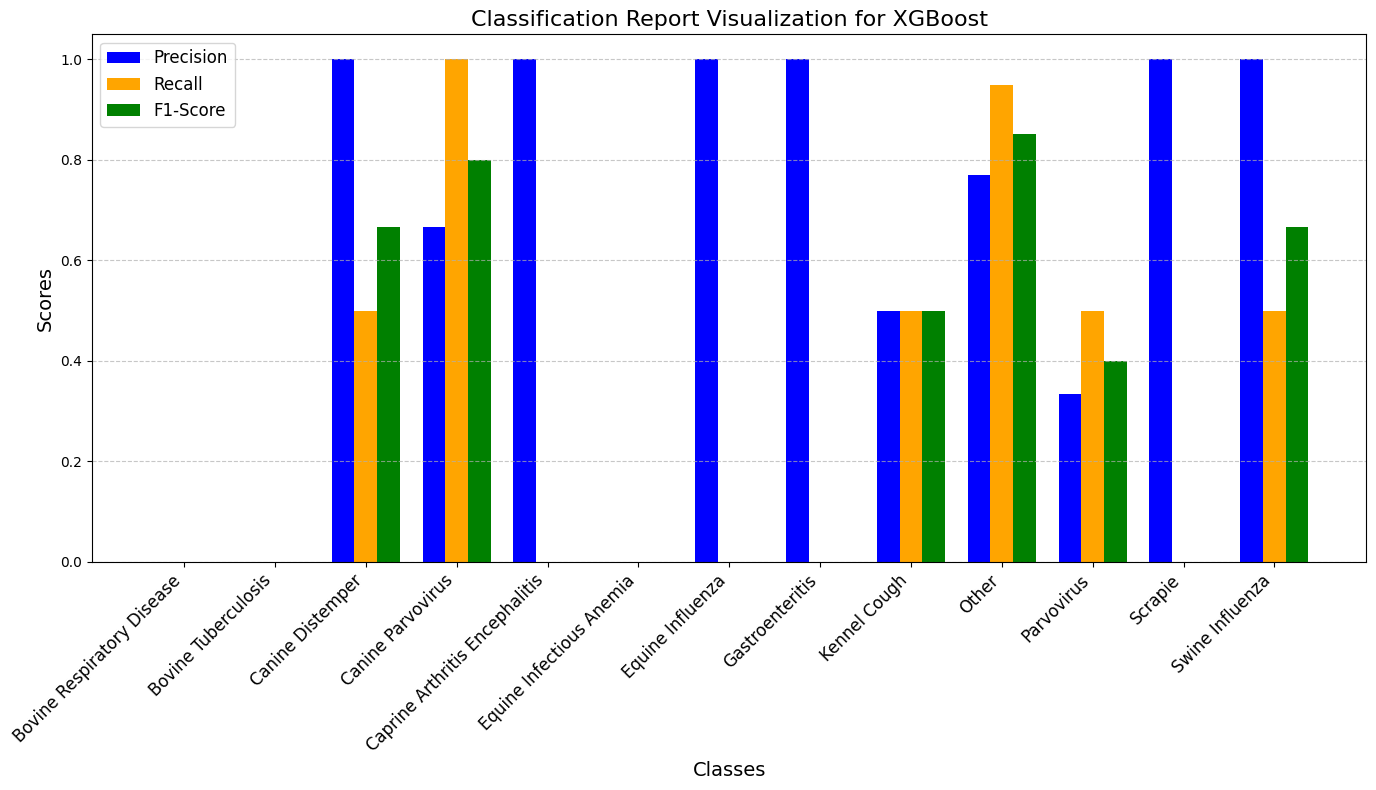

In [46]:
# Plot categories
x = np.arange(len(categories)) 
bar_width = 0.25

# Plot the bars
fig, ax = plt.subplots(figsize=(14, 8))
ax.bar(x - bar_width, precision, bar_width, label='Precision', color='blue')
ax.bar(x, recall, bar_width, label='Recall', color='orange')
ax.bar(x + bar_width, f1_score, bar_width, label='F1-Score', color='green')

# Label the plot
ax.set_xlabel('Classes', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title(f'Classification Report Visualization for {model_name}', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [47]:
df.head()

,Animal_Type,Breed,Age,Gender,Weight,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Duration,...,Lameness,Skin_Lesions,Nasal_Discharge,Eye_Discharge,Body_Temperature,Heart_Rate,Disease_Prediction,Duration_Num,Age_Group,Weight_Category
0,Dog,Labrador,4,Male,25.0,Fever,Lethargy,Appetite Loss,Vomiting,3 days,...,0,0,0,0,39.5,120,Parvovirus,3.0,Adult,Medium
1,Cat,Siamese,2,Female,4.5,Coughing,Sneezing,Eye Discharge,Nasal Discharge,1 week,...,0,0,1,1,38.9,150,Other,7.0,Young,Medium
2,Cow,Holstein,3,Female,600.0,Fever,Nasal Discharge,Labored Breathing,Coughing,5 days,...,0,0,1,0,40.1,90,Other,5.0,Young,NA
3,Dog,Beagle,1,Male,10.0,Diarrhea,Vomiting,Lethargy,Appetite Loss,2 days,...,0,0,0,0,39.2,130,Gastroenteritis,2.0,Infant,Small
4,Cat,Persian,5,Male,3.8,Lethargy,Appetite Loss,Skin Lesions,No,2 weeks,...,0,1,0,0,38.7,160,Other,14.0,Adult,Small
